#Tutorial 5 - DQN

Please follow this tutorial to understand the structure (code) of DQN algorithm.


### References:

Please follow [Human-level control through deep reinforcement learning](https://www.nature.com/articles/nature14236) for the original publication as well as the psuedocode. Watch Prof. Ravi's lectures on moodle or nptel for further understanding of the core concepts. Contact the TAs for further resources if needed.


In [1]:
'''
Installing packages for rendering the game on Colab
'''

!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1
!pip install gym[atari] > /dev/null 2>&1
!pip install git+https://github.com/tensorflow/docs > /dev/null 2>&1
!pip install gym[classic_control]

In [2]:
'''
A bunch of imports, you don't have to worry about these
'''

import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import namedtuple, deque
import torch.optim as optim
import datetime
import gym
from gym.wrappers.record_video import RecordVideo
import glob
import io
import base64
import matplotlib.pyplot as plt
from IPython.display import HTML
from pyvirtualdisplay import Display
import tensorflow as tf
from IPython import display as ipythondisplay
from PIL import Image
import tensorflow_probability as tfp

/usr/local/lib/python3.10/dist-packages/tensorflow_probability/python/__init__.py:57: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if (distutils.version.LooseVersion(tf.__version__) <


In [3]:
'''
Please refer to the first tutorial for more details on the specifics of environments
We've only added important commands you might find useful for experiments.
'''

'''
List of example environments
(Source - https://gym.openai.com/envs/#classic_control)

'Acrobot-v1'
'Cartpole-v1'
'MountainCar-v0'
'''

env = gym.make('CartPole-v1')
env.seed(0)

state_shape = env.observation_space.shape[0]
no_of_actions = env.action_space.n

print(state_shape)
print(no_of_actions)
print(env.action_space.sample())
print("----")

'''
# Understanding State, Action, Reward Dynamics

The agent decides an action to take depending on the state.

The Environment keeps a variable specifically for the current state.
- Everytime an action is passed to the environment, it calculates the new state and updates the current state variable.
- It returns the new current state and reward for the agent to take the next action

'''

state = env.reset()
''' This returns the initial state (when environment is reset) '''

print(state)
print("----")

action = env.action_space.sample()
''' We take a random action now '''

print(action)
print("----")

next_state, reward, done, info = env.step(action)
''' env.step is used to calculate new state and obtain reward based on old state and action taken  '''

print(next_state)
print(reward)
print(done)
print(info)
print("----")


4
2
0
----
[ 0.01369617 -0.02302133 -0.04590265 -0.04834723]
----
1
----
[ 0.01323574  0.17272775 -0.04686959 -0.3551522 ]
1.0
False
{}
----


/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)


## DQN

Using NNs as substitutes isn't something new. It has been tried earlier, but the 'human control' paper really popularised using NNs by providing a few stability ideas (Q-Targets, Experience Replay & Truncation). The 'Deep-Q Network' (DQN) Algorithm can be broken down into having the following components.

### Q-Network:
The neural network used as a function approximator is defined below

In [4]:
'''
### Q Network & Some 'hyperparameters'

QNetwork1:
Input Layer - 4 nodes (State Shape) \
Hidden Layer 1 - 128 nodes \
Hidden Layer 2 - 64 nodes \
Output Layer - 2 nodes (Action Space) \
Optimizer - zero_grad()
'''

import torch
import torch.nn as nn
import torch.nn.functional as F


'''
Bunch of Hyper parameters (Which you might have to tune later)
'''
BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 64         # minibatch size
GAMMA = 0.99            # discount factor
LR = 5e-4               # learning rate
UPDATE_EVERY = 20       # how often to update the network (When Q target is present)


class QNetwork1(nn.Module):

    def __init__(self, state_size, action_size, seed, fc1_units=128, fc2_units=64):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(QNetwork1, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)

    def forward(self, state):
        """Build a network that maps state -> action values."""
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

### Replay Buffer:

Recall why we use such a technique.

In [5]:
import random
import torch
import numpy as np
from collections import deque, namedtuple

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.

        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)

    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)

    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

## Tutorial Agent Code:


In [12]:
class TutorialAgent():

    def __init__(self, state_size, action_size, seed):

        ''' Agent Environment Interaction '''
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)

        ''' Q-Network '''
        self.qnetwork_local = QNetwork1(state_size, action_size, seed).to(device)
        self.qnetwork_target = QNetwork1(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)

        ''' Replay memory '''
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)

        ''' Initialize time step (for updating every UPDATE_EVERY steps)           -Needed for Q Targets '''
        self.t_step = 0

    def step(self, state, action, reward, next_state, done):

        ''' Save experience in replay memory '''
        self.memory.add(state, action, reward, next_state, done)

        ''' If enough samples are available in memory, get random subset and learn '''
        if len(self.memory) >= BATCH_SIZE:
            experiences = self.memory.sample()
            self.learn(experiences, GAMMA)

        """ +Q TARGETS PRESENT """
        ''' Updating the Network every 'UPDATE_EVERY' steps taken '''
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:

            self.qnetwork_target.load_state_dict(self.qnetwork_local.state_dict())

    def act(self, state, para=0.1):  # para is epsilon for ε-greedy
        # Existing ε-greedy action selection logic, using para as epsilon
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        if random.random() > para:  # Use para as epsilon
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences, gamma):
        """ +E EXPERIENCE REPLAY PRESENT """
        states, actions, rewards, next_states, dones = experiences

        ''' Get max predicted Q values (for next states) from target model'''
        Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)

        ''' Compute Q targets for current states '''
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))

        ''' Get expected Q values from local model '''
        Q_expected = self.qnetwork_local(states).gather(1, actions)

        ''' Compute loss '''
        loss = F.mse_loss(Q_expected, Q_targets)

        ''' Minimize the loss '''
        self.optimizer.zero_grad()
        loss.backward()

        ''' Gradiant Clipping '''
        """ +T TRUNCATION PRESENT """
        for param in self.qnetwork_local.parameters():
            param.grad.data.clamp_(-1, 1)

        self.optimizer.step()

### Here, we present the DQN algorithm code.

In [15]:
''' Defining DQN Algorithm '''

state_shape = env.observation_space.shape[0]
action_shape = env.action_space.n


def dqn(n_episodes=10000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):

    scores_window = deque(maxlen=100)
    ''' last 100 scores for checking if the avg is more than 195 '''

    eps = eps_start
    ''' initialize epsilon '''

    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            next_state, reward, done, _ = env.step(action)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break

        scores_window.append(score)

        eps = max(eps_end, eps_decay*eps)
        ''' decrease epsilon '''

        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")

        if i_episode % 100 == 0:
           print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=195.0:
           print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
           break
    return True

''' Trial run to check if algorithm runs and saves the data '''

# begin_time = datetime.datetime.now()

# agent = TutorialAgent(state_size=state_shape,action_size = action_shape,seed = 0)
# dqn()

# time_taken = datetime.datetime.now() - begin_time

# print(time_taken)

' Trial run to check if algorithm runs and saves the data '

### **Task 1a**  
Understand the core of the algorithm, follow the flow of data. Identify the exploration strategy used.
### **Task 1b**
Out of the two exploration strategies discussed in class ($ϵ$-greedy & Softmax). Implement the strategy that's not used here.
### **Task 1c**
How fast does the agent 'solve' the environment in terms of the number of episodes?
(Cartpole-v1 defines "solving" as getting average reward of 195.0 over 100 consecutive trials)

How 'well' does the agent learn? (reward plot?) The above two are some 'evaluation metrics' you can use to comment on the performance of an algorithm.

Please compare DQN (using $\epsilon$-greedy) with DQN (using softmax). Think along the lines of 'no. of episodes', 'reward plots', 'compute time', etc. and add a few comments.



#### **Submission Steps**

#### Task 1: Add a text cell with the answer.

#### Task 2: Add a code cell below task 1 solution and use 'Tutorial Agent Code' to build your new agent (with a different exploration strategy).

#### Task 3: Add a code cell below task 2 solution running both the agents to solve the CartPole v-1 environment and add a new text cell below it with your inferences.

### **Task 1**

**The core of the algorithm provided is a Deep Q-Network (DQN) approach for solving RL problems. DQN uses a neural network to approximate the Q-value function, which represents the expected rewards for taking an action in gieven state. The algorithm involves the following key components and process flow:**


- **Environment Interaction**: The agent intract with env by taking action by given polciy , recieving feedback in terms of next state and rewards.
- **Replay Buffer:** To break the correlation between consecutive samples algo stores agent's experience in buffer at each time step and later samples mini batches from buffer to train nn.
- **Q-Network**: Q-Network predicts Q-values for all possible actions in a given state. .
- **Target Network:** Target network is used to stabilize learning. This network is used to calculate the target Q-value during training.
- **Exploration Strategy:** The exploration policy used here is the ε-greedy method,  The value of ε decreases over time, decreasing exploration and increasing exploitation.


### **Task 2**
Out of the two exploration strategies discussed in class ($ϵ$-greedy & Softmax). Implement the strategy that's not used here.



In [27]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
from collections import deque, namedtuple

class SoftmaxTutorialAgent(TutorialAgent):
    def __init__(self, state_size, action_size, seed, tau=1.0):
        super(SoftmaxTutorialAgent, self).__init__(state_size, action_size, seed)
        self.tau = tau

    def softmax(self, action_values, tau):
        # Subtract the max action value for numerical stability
        max_action_value = np.max(action_values)
        adjusted_values = action_values - max_action_value
        exp_values = np.exp(adjusted_values / tau)
        probabilities = exp_values / np.sum(exp_values)
        return probabilities

    def act(self, state, tau=None):
        if tau is None:
            tau = self.tau
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state).cpu().data.numpy().squeeze()
        self.qnetwork_local.train()

        probabilities = self.softmax(action_values, tau)
        action = np.random.choice(np.arange(self.action_size), p=probabilities)

        return action



In [36]:
def dqn(agent, n_episodes=2000, max_t=1000, start_val=1.0, end_val=0.01, decay=0.995):
    scores = []

    scores_window = deque(maxlen=100)
    ''' last 100 scores for checking if the avg is more than 195 '''

    val = start_val  # either ε_start or τ_start, depending on the agent
    ''' initialize tauilon '''

    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        score = 0
        for t in range(max_t):
            action = agent.act(state, val)
            next_state, reward, done, _ = env.step(action)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break

        scores.append(score)
        scores_window.append(score)

        # if not isinstance(agent, SoftmaxTutorialAgent):
        val = max(end_val, decay*val)
        ''' decrease val '''

        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window) >= 195.0:
            print(f'\n{type(agent).__name__} solved the environment in {i_episode} episodes!\tAverage Score: {np.mean(scores_window):.2f}')
            break

    return scores
''' Trial run to check if algorithm runs and saves the data '''

' Trial run to check if algorithm runs and saves the data '

### Task 3

In [38]:
epsilon_greedy_agent = TutorialAgent(state_shape, action_shape, seed=0)
softmax_agent = SoftmaxTutorialAgent(state_shape, action_shape, seed=0, tau=1.0)

In [39]:
# Training ε-greedy agent
print("Training ε-greedy agent:")

begin_time = datetime.datetime.now()

epsilon_greedy_scores = dqn(epsilon_greedy_agent, start_val=1.0, end_val=0.01, decay=0.995)

time_taken = datetime.datetime.now() - begin_time

print(time_taken)

print("------------------------------------------------------------------------------")


Training ε-greedy agent:
Episode 100	Average Score: 37.25
Episode 200	Average Score: 136.89
Episode 242	Average Score: 195.85
TutorialAgent solved the environment in 242 episodes!	Average Score: 195.85
0:01:28.641211
------------------------------------------------------------------------------


In [40]:
# Training Softmax agent with tau
print("\nTraining Softmax agent with tau:")

begin_time = datetime.datetime.now()

softmax_scores = dqn(softmax_agent,  start_val=1.0, end_val=0.01, decay=0.995)

time_taken = datetime.datetime.now() - begin_time

print(time_taken)


Training Softmax agent with tau:
Episode 100	Average Score: 150.24
Episode 116	Average Score: 195.56
SoftmaxTutorialAgent solved the environment in 116 episodes!	Average Score: 195.56
0:01:04.817955


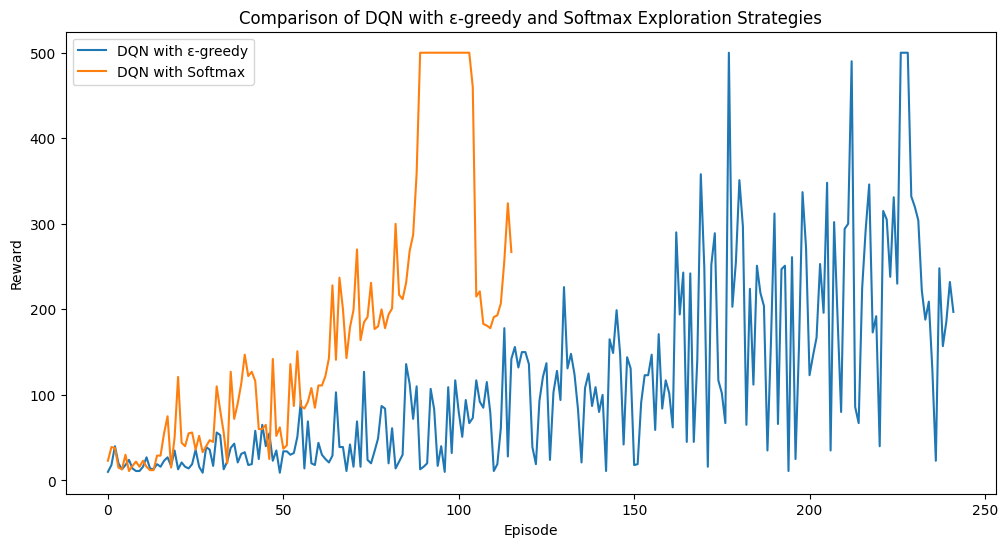

In [42]:
# Plotting the results
plt.figure(figsize=(12, 6))
plt.plot(epsilon_greedy_scores, label='DQN with ε-greedy')
plt.plot(softmax_scores, label='DQN with Softmax')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Comparison of DQN with ε-greedy and Softmax Exploration Strategies')
plt.legend()
plt.show()

### Inference

- Time differnce for learning between Epsilon-greedy and softmax policy is 24 seconds.
- Softmax taking nearly half of the number of epsidos to learn taken by epsilon greedy.
- Epsilon peeks action randomly unlike softmax which try to balance exploration and exploitation or select action selection based on probabilities.